# 1. Specify the system type

In [1]:
import warnings
warnings.filterwarnings("ignore")

# specify the system
from RBG_Maxwell.Collision_database.select_system import which_system

plasma_system = 'Fusion_system'
which_system(plasma_system)

from RBG_Maxwell.Collision_database.Fusion_system.collision_type import collision_type_for_all_species

# import ray
# ray.shutdown()
# ray.init(_temp_dir='/data/sunmingyan')

# 2. Specify the coefficient for unit conversion 

In [2]:
from RBG_Maxwell.Unit_conversion.main import determine_coefficient_for_unit_conversion, unit_conversion
import numpy as np

In [3]:
# here we use a pure electron system
# the relavant PIC code is given by Jian-Nan Chen

# give the quantities in SI
# the spatial grid is chosen to be dx=dy=dz=10**(-4) m
dx = dy = 5*10**(-5)
dz = 10**(-5)

# velocity
v = 0
v_max = 1.5*10**7

# charge
Q = 1.6*10**(-19) 

# maximum momentum is roughly 10**(-30)kg*10**5m/s
momentum = 10**(-30)*v_max

# the momentum grid is set to be 
# npy=100, npx=npz=1, half_px=half_pz=half_py~10**(-25)
dp = momentum/100
dp_volume = momentum**3/100

# time scale
dt = 10**(-13)

n_max = 5*10**(-14)/(1.6*10**(-19))/101*10
n_average = 5*10**(-14)/(1.6*10**(-19))/101/251


E = 10**8
B = 10

# Now find the coefficient
hbar, c, lambdax, epsilon0 = determine_coefficient_for_unit_conversion(dt, dx, dx*dy*dz, dp, dp_volume,\
                                                                       n_max, n_average, v_max, E, B)

Searching for proper scaling parameters...
This may take several minutes.


In [4]:
hbar, c, lambdax, epsilon0

(1e-07, 1000000000, 1e-22, 1e-07)

In [5]:
conversion_table = \
unit_conversion('SI_to_LHQCD', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)
conversion_table_reverse = \
unit_conversion('LHQCD_to_SI', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)

# 3. Specify the configurations for plasma evolution

In [6]:
# import the main class Plasma
from RBG_Maxwell.Plasma.main import Plasma

In [7]:
# time step, and spatial infinitesimals
# dt is 10**(-13) s, dx = dy = dz = 10**(-5) m
dt, dx, dy, dz = dt*conversion_table['second'], \
                 dx*conversion_table['meter'], \
                 dy*conversion_table['meter'], \
                 dz*conversion_table['meter']

# we have only one type of particle e-
num_particle_species = 1

# treat the electron as classical particles
particle_type = np.array([0])

# masses, charges and degenericies are
masses, charges, degeneracy = np.array([9.11*10**(-31)*conversion_table['kilogram']]), \
                              np.array([-1.6*10**(-19)*conversion_table['Coulomb']]),\
                              np.array([1.])

# momentum grids
npx, npy, npz = 1, 200, 1

# half_px, half_py, half_pz
# momentum range for x and z direction are not import in this case
half_px, half_py, half_pz = np.array([9.11*10**(-31)*v_max*conversion_table['momentum']]), \
                            np.array([9.11*10**(-31)*v_max*conversion_table['momentum']]),\
                            np.array([9.11*10**(-31)*v_max*conversion_table['momentum']])

dpx, dpy, dpz = 2*half_px/npx, 2*half_py/npy, 2*half_pz/npz

# load the collision matrix
flavor, collision_type, particle_order = collision_type_for_all_species()
expected_collision_type = ['2TO2']

# 4. Specify the parallel configuration for plasma evolution

In [8]:
# number of spatial grids
# must be integers and lists
# odd numbers are recomended
# the maximum spatial gird is limited by CUDA, it's about nx*ny*nz~30000 for each card
nx_o, ny_o, nz_o = [1], [250], [111]

# value of the left boundary
# this is the 
x_left_bound_o, y_left_bound_o, z_left_bound_o = [-0.5*dx],\
                                                 [-ny_o[0]/2*dy],\
                                                 [-55.5*dz]

# number samples gives the number of sample points in MC integration
num_samples = 100

# Only specify one spatial region
number_regions = 1

# each spatial should use the full GPU, this number can be fractional if many regions are chosen
# and only one GPU is available
num_gpus_for_each_region = 1


# since only one region is specified, this will be empty
sub_region_relations = {'indicator': [[]],\
                        'position': [[]]}

# if np.ones are used, the boundaries are absorbing boundaries
# if np.zeros are used, it is reflection boundary
# numbers in between is also allowed
boundary_configuration = {}
for i_reg in range(number_regions):
    bound_x = np.ones([ny_o[i_reg], nz_o[i_reg]])
    bound_y = np.ones([nz_o[i_reg], nx_o[i_reg]])
    bound_z = np.ones([nx_o[i_reg], ny_o[i_reg]])
    boundary_configuration[i_reg] = (bound_x, bound_y, bound_z)
dn_dv = 5*10**(-14)/(1.6*10**(-19))/(101*dx*dy*dz*dpx*dpy*dpz)

# 5. Specify the initial and boundary condition for plasma evolution

In [9]:
num_momentum_levels = 1

# iniital distribution function
f = {}
for i_reg in range(number_regions):
    f[i_reg] = np.zeros([num_momentum_levels, num_particle_species,\
                         nx_o[i_reg], ny_o[i_reg], nz_o[i_reg], npx, npy, npz])

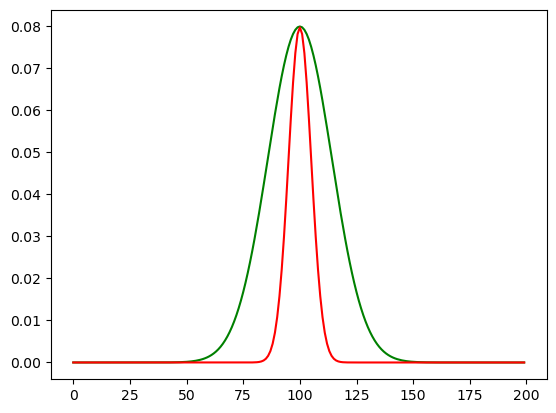

In [10]:
import math
import matplotlib.pyplot as plt
sigma = 5
x = np.arange(200)
f_p = np.zeros(200)
f_p1 = np.zeros(200)
for i in range(0,200):
    f_p[i] = np.exp(-1/2*0.005*(i-100)**(2))*0.08#*dn_dv
    f_p1[i] = 1/math.sqrt(2*math.pi*sigma**2)*np.exp(-(np.array(i-100))**2/(2*sigma**2))#*dn_dv
#     f_p[i] = math.exp(-(i/sigma)**2)*dn_dv
plt.plot(x,f_p,'green')
plt.plot(x,f_p1,'red')

In [11]:
dn_dv = 5*10**(-14)/(1.6*10**(-19))/(101*dx*dy*dz*dpx*dpy*dpz)
sigma = 2.7986
# 2.7986
import math
for j in range(2):
    for i in range(3,200):
        f[0][0, 0, 0,124+j,5:106,0,i,0] = np.exp(-1/2*0.005*(i-100)**(2))*0.08*dn_dv/100

In [12]:
f[0][0][0].sum()*dx*dy*dz*dpx*dpy*dpz

array([17724.53850899])

In [13]:
for i_reg in range(number_regions):
    f[i_reg] = f[i_reg].reshape([num_momentum_levels, num_particle_species,\
                                 nx_o[i_reg]*ny_o[i_reg]*nz_o[i_reg]*npx*npy*npz])

'''
We add an external magnetic field of 10 T in the +y direction
'''
BBy = [10*conversion_table['Tesla']*np.ones(nx_o[0]*ny_o[0]*nz_o[0])]
BEx, BEy, BEz, BBx, BBz = [0],[0],[0],[0],[0]

plasma = Plasma(f, dt, \
                nx_o, ny_o, nz_o, dx, dy, dz, boundary_configuration, \
                x_left_bound_o, y_left_bound_o, z_left_bound_o, \
                npx, npy, npz, half_px, half_py, half_pz,\
                masses, charges, sub_region_relations,\
                flavor, collision_type, particle_type,\
                degeneracy, expected_collision_type,\
                num_gpus_for_each_region,\
                hbar, c, lambdax, epsilon0, \
                num_samples = 100, drift_order = 1,\
                rho_J_method="raw", GPU_ids_for_each_region = ["1"])

[419]


2024-05-25 15:59:49,368	INFO worker.py:1622 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8271 


(Plasma_single_GPU pid=1546466) Using context GPU-16b86954-6394-703e-7cf8-9ee8e9904aeb for region 0.


# 6. Perform evolution

In [14]:
dt*conversion_table_reverse['TO_second']*10001*10**9

1.0001

In [17]:
n_step = 40001
number_rho = []
EM = []
charged_rho = []
dis = []
VT= []
DT = []
Force = []
import time
start_time = time.time()
for i_time in range(n_step):  
    
    if i_time%1000 == 0:
        dis.append(plasma.acquire_values("Distribution"))            
    plasma.proceed_one_step(i_time, n_step, processes = {'VT':1., 'DT':1., 'CT':0.},\
                            BEx = BEx, BEy = BEy, BEz = BEz, BBx = BBx, BBy = BBy, BBz = BBz)
    if i_time%1000 == 0:     
        print('Updating the {}-th time step'.format(i_time))
        number_rho.append(plasma.acquire_values("number_rho/J"))
        charged_rho.append(plasma.acquire_values("Electric rho/J"))
        Force.append(plasma.acquire_values("Forces"))
#     number_rho.append(plasma.acquire_values("number_rho/J"))
    EM.append(plasma.acquire_values('EM fields on current region'))
end_time = time.time()
print((end_time-start_time)/3600,'hours')

Updating the 0-th time step
Updating the 1000-th time step
Updating the 2000-th time step
Updating the 3000-th time step
Updating the 4000-th time step
Updating the 5000-th time step
Updating the 6000-th time step
Updating the 7000-th time step
Updating the 8000-th time step
Updating the 9000-th time step
Updating the 10000-th time step
Updating the 11000-th time step
Updating the 12000-th time step
Updating the 13000-th time step
Updating the 14000-th time step
Updating the 15000-th time step
Updating the 16000-th time step
Updating the 17000-th time step
Updating the 18000-th time step
Updating the 19000-th time step
Updating the 20000-th time step
1.1081450355052949 hours


In [ ]:
np.save("plane wave dis", arr=dis )

# 7. Results

In [16]:
len(number_rho)

21

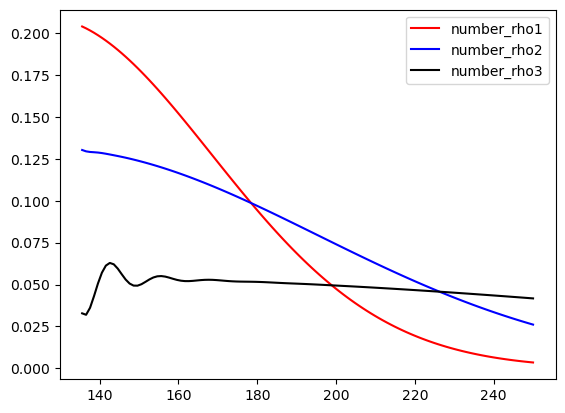

In [29]:
import matplotlib.pyplot as plt
number_rho1 = np.zeros(ny_o[0])
number_rho2 = np.zeros(ny_o[0])
number_rho3 = np.zeros(ny_o[0])
number = 10
for i in range(ny_o[0]):
    number_rho1[i] = (number_rho[10][0][0])[0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0][i].sum()
    number_rho2[i] = (number_rho[16][0][0])[0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0][i].sum()
    number_rho3[i] = (number_rho[40][0][0])[0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0][i].sum()
x = np.linspace(0,ny_o[0],num=ny_o[0])

plt.plot(x[int(ny_o[0]/2+number):ny_o[0]], number_rho1[int(ny_o[0]/2+number):ny_o[0]], color='red', label='number_rho1')
plt.plot(x[int(ny_o[0]/2+number):ny_o[0]],number_rho2[int(ny_o[0]/2+number):ny_o[0]] , color='blue', label='number_rho2')
plt.plot(x[int(ny_o[0]/2+number):ny_o[0]],number_rho3[int(ny_o[0]/2+number):ny_o[0]] , color='black', label='number_rho3')
# # plt.plot(x, number_rho1 ,color='red', label='number_rho1')
# plt.plot(x,number_rho2 , color='blue', label='number_rho2')
# plt.plot(x,number_rho3 , color='black', label='number_rho3')
plt.legend(loc='best')
plt.show()


In [ ]:
# spatial distribution
import matplotlib.pyplot as plt
xi, yi = np.mgrid[1:251:1,1:112:1]
fig, axes = plt.subplots(ncols=5, nrows=2, figsize = (15,5))
for jj in range(2):
    for kk in range(5):
        axes[jj,kk].pcolormesh(xi, yi, number_rho[(jj*5+kk)+30][0][0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0])
        # axes[jj,kk].contour(xi, yi, data[jj*5+kk].sum(axis=-1)[0,1])

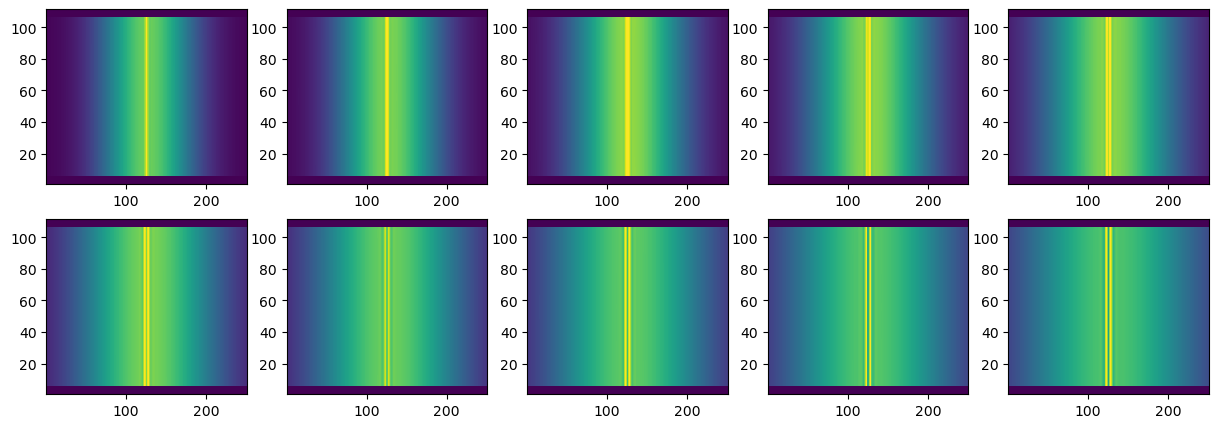

In [20]:
# spatial distribution
import matplotlib.pyplot as plt
xi, yi = np.mgrid[1:251:1,1:112:1]
fig, axes = plt.subplots(ncols=5, nrows=2, figsize = (15,5))
for jj in range(2):
    for kk in range(5):
        axes[jj,kk].pcolormesh(xi, yi, number_rho[(jj*5+kk+10)][0][0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0])
        # axes[jj,kk].contour(xi, yi, data[jj*5+kk].sum(axis=-1)[0,1])